In [8]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.applications import ResNet50,EfficientNetB0
from tensorflow.keras.applications.resnet50 import preprocess_input
import tensorflow as tf
from tensorflow import keras
from keras import layers
from tensorflow.keras.models import Model
import random
import cv2
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical

# **Load Data**

In [9]:
data_path='./dermnet/train'

In [10]:
train_data = []
val_data = []

for folder in os.listdir(data_path):
    folder_path = os.path.join(data_path, folder)
    file = os.listdir(folder_path)
    num_train = int(0.8 * len(file))
    files_train = random.sample(file, num_train)
    files_val = list(set(file) - set(files_train))
    
    for file in files_train:
        file_path = os.path.join(folder_path, file)
        img = cv2.imread(file_path)
        img = cv2.resize(img, (224,224))
        train_data.append((img, folder))
        
    for file in files_val:
        file_path = os.path.join(folder_path, file)
        img = cv2.imread(file_path)
        img = cv2.resize(img, (224,224))
        val_data.append((img, folder))

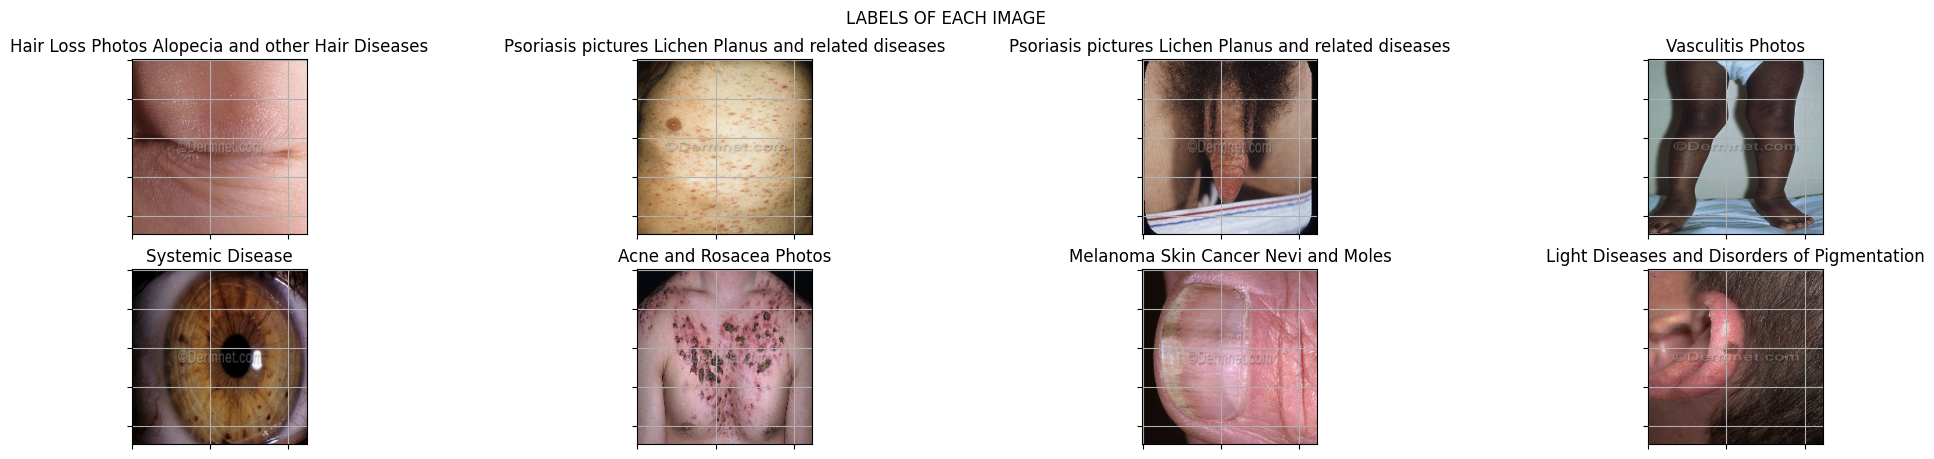

In [11]:
fig, axes = plt.subplots(2, 4, figsize=(25, 5))
plt.suptitle('LABELS OF EACH IMAGE')

for (img, label), ax in zip(random.sample(train_data, 8), axes.flatten()):
    ax.xaxis.set_ticklabels([])
    ax.yaxis.set_ticklabels([])
    ax.grid(True)
    ax.set_title(label)
    ax.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB) )

plt.show()

# Pre-Process Data

In [12]:

X_train, y_train = zip(*train_data)
X_val, y_val = zip(*val_data)

X_train = preprocess_input(np.array(X_train))
X_val = preprocess_input(np.array(X_val))

le = LabelEncoder()
y_train_encoded = le.fit_transform(y_train)
y_val_encoded = le.transform(y_val)

y_train_one_hot = to_categorical(y_train_encoded, 23)
y_val_one_hot = to_categorical(y_val_encoded, 23)
np.save('label_classes.npy', le.classes_)

# Build Model

In [13]:
num_classes = 23
image_resize = 224
EPOCHS=20
Batch_size=32
input_shape = (image_resize, image_resize, 3)

In [18]:
resnet_base = ResNet50(input_shape=input_shape, include_top=False, weights='imagenet')
efficientnet_base = EfficientNetB0(input_shape=input_shape, include_top=False, weights='imagenet')

In [20]:
input_layer = keras.Input(shape=input_shape)

resnet_output = resnet_base(input_layer)
efficientnet_output = efficientnet_base(input_layer)
resnet_gap = layers.GlobalAveragePooling2D()(resnet_output)
efficientnet_gap = layers.GlobalAveragePooling2D()(efficientnet_output)

# Concatenate 
combined_output = layers.Concatenate()([resnet_gap, efficientnet_gap])
combined_output = layers.Dropout(0.5)(combined_output)  
dense_layer = layers.Dense(256, activation='relu')(combined_output)
output_layer = layers.Dense(num_classes, activation='softmax')(dense_layer)

In [ ]:
ensemble_model = Model(inputs=input_layer, outputs=output_layer)
ensemble_model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Train

In [ ]:
from keras.callbacks import ModelCheckpoint, EarlyStopping
custom_early_stopping = EarlyStopping(
    monitor='val_loss', 
    patience=10, 
    min_delta=0.001, 
    mode='min'
)

In [ ]:
history=ensemble_model.fit(
    X_train, y_train_one_hot, validation_data=(X_val, y_val_one_hot),
                   epochs = EPOCHS, batch_size=Batch_size,callbacks=[custom_early_stopping]
)

# Print the model summary to check the structure
ensemble_model.summary()
ensemble_model.save('./my_model.h5')

In [ ]:
train_loss = history.history['loss']
val_loss = history.history['val_loss']

# Create an array representing the number of epochs
epochs = range(1, len(train_loss) + 1)

# Plot the training and validation losses
plt.plot(epochs, train_loss,label='Training loss', marker='o')
plt.plot(epochs, val_loss,label='Validation loss', marker='o')
plt.title('Training and Validation Losses')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Show the plot
plt.show()

In [ ]:
train_loss = history.history['accuracy']
val_loss = history.history['val_accuracy']

# Create an array representing the number of epochs
epochs = range(1, len(train_loss) + 1)

# Plot the training and validation losses
plt.plot(epochs, train_loss,label='Training accuracy', marker='o')
plt.plot(epochs, val_loss,label='Validation accuracy', marker='o')
plt.title('Training and Validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Acc')
plt.legend()

# Show the plot
plt.show()